In [8]:
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics
import matplotlib.pyplot as plt

In [9]:
col = google_cmip_col()
col

Future exception was never retrieved
future: <Future finished exception=ClientConnectionError('Connection lost: [SSL: APPLICATION_DATA_AFTER_CLOSE_NOTIFY] application data after close notify (_ssl.c:2706)')>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/asyncio/sslproto.py", line 651, in _do_shutdown
    self._sslobj.unwrap()
  File "/srv/conda/envs/notebook/lib/python3.12/ssl.py", line 920, in unwrap
    return self._sslobj.shutdown()
           ^^^^^^^^^^^^^^^^^^^^^^^
ssl.SSLError: [SSL: APPLICATION_DATA_AFTER_CLOSE_NOTIFY] application data after close notify (_ssl.c:2706)

The above exception was the direct cause of the following exception:

aiohttp.client_exceptions.ClientConnectionError: Connection lost: [SSL: APPLICATION_DATA_AFTER_CLOSE_NOTIFY] application data after close notify (_ssl.c:2706)


,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


# Precipitation

In [10]:
cat = col.search(
    source_id='CESM2',
    variable_id='pr',
    table_id='Amon',
    experiment_id='historical',
    member_id='r1i1p1f1',
)

In [11]:
ds_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True})
ds = list(ds_dict.values())[0]
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.Dataset> Size: 438MB
Dimensions:         (lat: 192, nbnd: 2, lon: 288, member_id: 1,
                     dcpp_init_year: 1, time: 1980)
Coordinates:
  * lat             (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    lat_bnds        (lat, nbnd) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon             (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    lon_bnds        (lon, nbnd) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:...
    time_bnds       (time, nbnd) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: nbnd
Data variables:
    pr              (member_id, dcpp_init_year, time, lat, lon) float32 438MB dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            219000.0
    case_id:                          15
    ...                               ...
    intake_esm_attrs:variable_id:     pr
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/NCAR/CESM2/histor...
    intake_esm_attrs:version:         20190401
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.Amon.gn

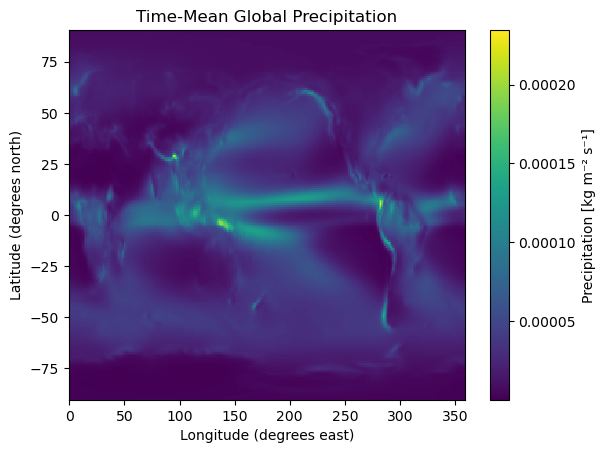

In [16]:
mean_precip = ds['pr'].mean(dim='time')
mean_precip.plot()
plt.title("Time-Mean Global Precipitation")
plt.xlabel("Longitude (degrees east)")
plt.ylabel("Latitude (degrees north)")
plt.gca().collections[0].colorbar.set_label("Precipitation [kg m⁻² s⁻¹]")
plt.show()

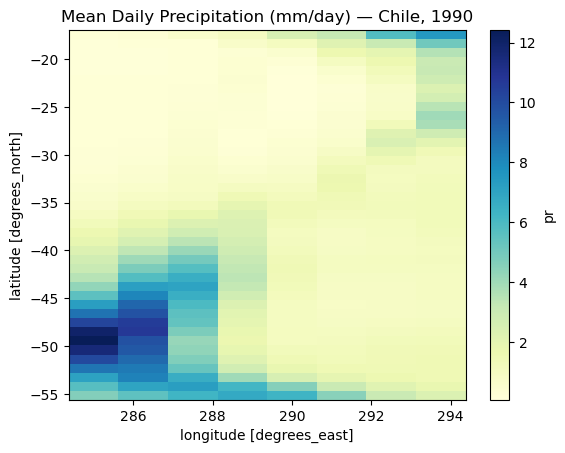

In [13]:
# Step 1 — Subset the dataset over Chile and for the year 1990
# ----------------------------------------
# Chile's lat/lon box (in native 0–360 longitude format):
#   lat: -56 to -17
#   lon: -76 to -66 → becomes 284 to 294 in 0–360 format

ds_chile = ds.sel(
    time=slice('1990-01-01'),
    lat=slice(-56, -17),
    lon=slice(284, 294)  # 360 system
)

# Step 2 — Select and convert precipitation from kg/m²/s to mm/day
# --------------------------------------------------------------
# Remember: 1 kg/m²/s = 86400 mm/day
pr = ds_chile['pr'].isel(member_id=0, dcpp_init_year=0) * 86400

# Step 3 — Average over time
pr_mean = pr.mean(dim='time')

# Step 4 — Plotting
pr_mean.plot(cmap='YlGnBu')
plt.title('Mean Daily Precipitation (mm/day) — Chile, 1990')
plt.show()

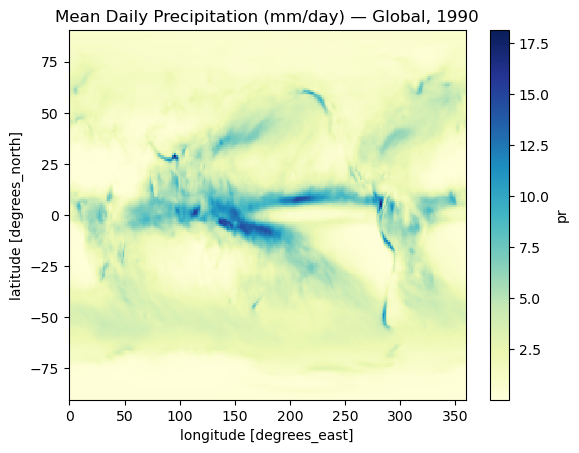

In [56]:
import matplotlib.pyplot as plt

# Step 1 — Subset full year 1990
ds_1990 = ds.sel(time=slice('1990-01-01', '1990-12-31'))

# Step 2 — Convert units: kg/m²/s → mm/day
pr_1990 = ds_1990['pr'].isel(member_id=0, dcpp_init_year=0) * 86400

# Step 3 — Mean over time (annual average)
pr_1990_mean = pr_1990.mean(dim='time')

# Step 4 — Plot global map
pr_1990_mean.plot(cmap='YlGnBu')
plt.title('Mean Daily Precipitation (mm/day) — Global, 1990')
plt.show()

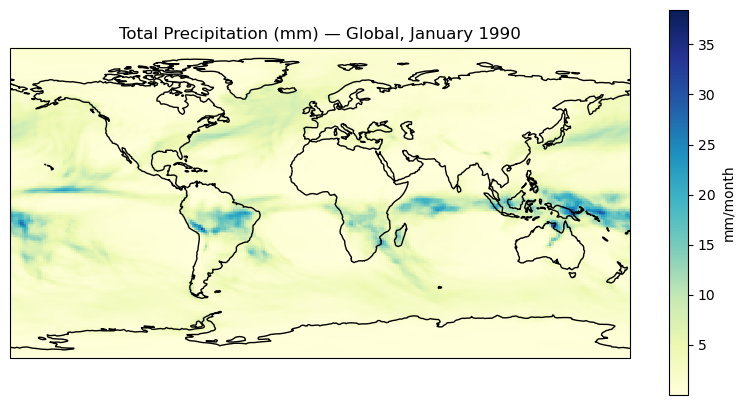

In [60]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Step 1 — Select January 1990
ds_pr_jan1990 = ds.sel(time=slice('1990-01-01', '1990-01-31'))

# Step 2 — Convert precipitation from kg/m²/s to mm/day, then to mm/month
# 1 kg/m²/s = 86400 mm/day → then multiply by number of days
pr_jan1990 = ds_pr_jan1990['pr'].isel(member_id=0, dcpp_init_year=0) * 86400  # mm/day

# Step 3 — Sum over all days to get monthly total (in mm)
pr_jan1990_total = pr_jan1990.sum(dim='time')

# Step 4 — Plot total precipitation
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
pr_jan1990_total.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='YlGnBu', cbar_kwargs={'label': 'mm/month'})
ax.coastlines()
ax.set_title('Total Precipitation (mm) — Global, January 1990')
plt.show()

# Temperature


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


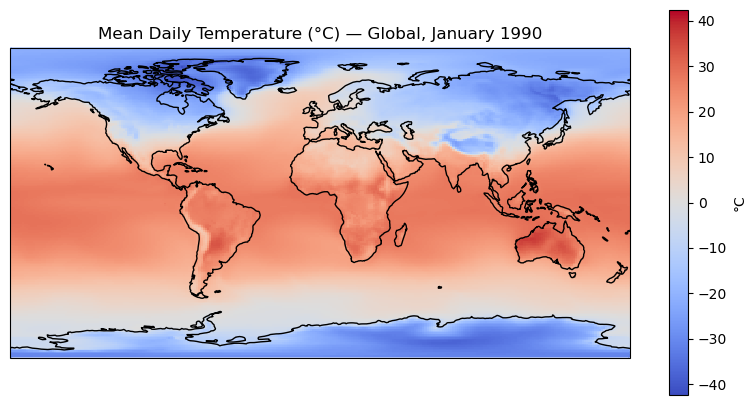

In [61]:
# Step 1 — Search for temperature data
cat_tas = col.search(
    source_id='CESM2',
    variable_id='tas',          # tas = near-surface air temperature
    table_id='Amon',
    experiment_id='historical',
    member_id='r1i1p1f1',
)

# Step 2 — Load dataset
ds_dict_tas = cat_tas.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True})
ds_tas = list(ds_dict_tas.values())[0]

# Step 3 — Select January 1990
ds_tas_jan1990 = ds_tas.sel(time=slice('1990-01-01', '1990-01-31'))

# Step 4 — Convert to Celsius and average over time
tas_jan1990 = ds_tas_jan1990['tas'].isel(member_id=0, dcpp_init_year=0) - 273.15  # Convert K → °C
tas_jan1990_mean = tas_jan1990.mean(dim='time')

# Step 5 — Plot with coastlines
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
tas_jan1990_mean.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': '°C'})
ax.coastlines()
ax.set_title('Mean Daily Temperature (°C) — Global, January 1990')
plt.show()

# Chile

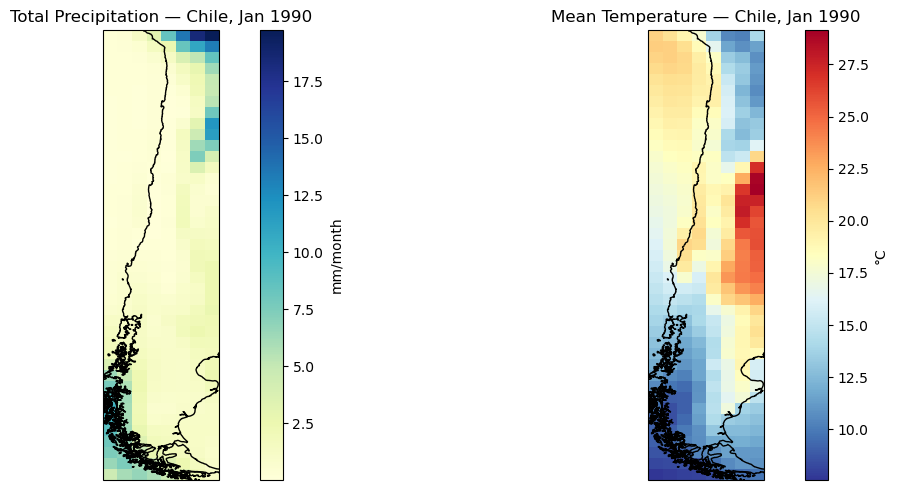

In [63]:
# ---- STEP 1: Define spatial and temporal bounds for Chile
chile_lats = slice(-56, -17)   # From South to North
chile_lons = slice(284, 294)   # 66°W to 76°W in 0–360 format
time_jan1990 = slice('1990-01-01', '1990-01-31')

# ---- STEP 2: Extract precip (mm/day) and sum it over time
pr_jan90 = ds['pr'].sel(time=time_jan1990, lat=chile_lats, lon=chile_lons)
pr_jan90 = pr_jan90.isel(member_id=0, dcpp_init_year=0) * 86400  # mm/day
pr_jan90_total = pr_jan90.sum(dim='time')  # mm/month

# ---- STEP 3: Extract temp (°C) and average over time
tas_jan90 = ds_tas['tas'].sel(time=time_jan1990, lat=chile_lats, lon=chile_lons)
tas_jan90 = tas_jan90.isel(member_id=0, dcpp_init_year=0) - 273.15  # convert K to °C
tas_jan90_mean = tas_jan90.mean(dim='time')  # °C

# ---- STEP 4: Plot both maps
fig, axes = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot Precipitation
pr_jan90_total.plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap='YlGnBu', cbar_kwargs={'label': 'mm/month'})
axes[0].set_title('Total Precipitation — Chile, Jan 1990')
axes[0].coastlines()

# Plot Temperature
tas_jan90_mean.plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap='RdYlBu_r', cbar_kwargs={'label': '°C'})
axes[1].set_title('Mean Temperature — Chile, Jan 1990')
axes[1].coastlines()

plt.tight_layout()
plt.show()

# Chile 1990 vs. 2011

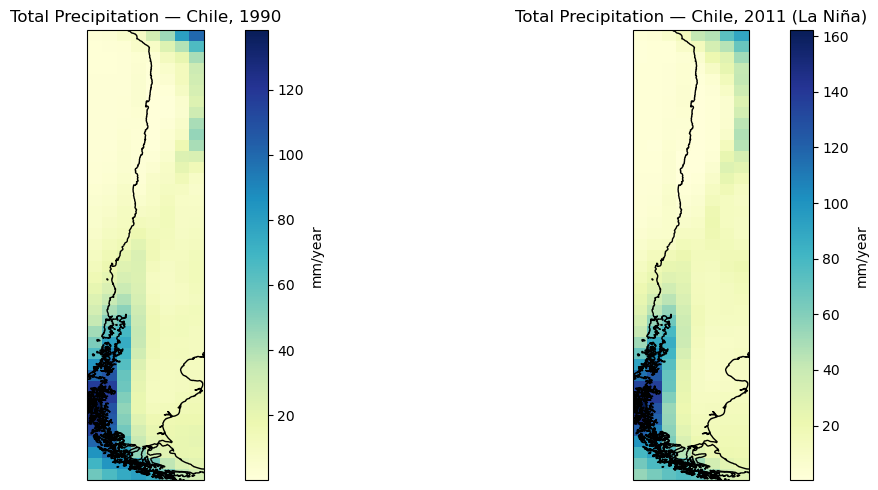

In [65]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# --- Chile bounds (lat/lon in 0–360 format)
lat_chile = slice(-56, -17)
lon_chile = slice(284, 294)

# --- Select annual periods
ds_pr_1990 = ds['pr'].sel(time=slice('1990-01-01', '1990-12-31'), lat=lat_chile, lon=lon_chile)
ds_pr_2011 = ds['pr'].sel(time=slice('2011-01-01', '2011-12-31'), lat=lat_chile, lon=lon_chile)

# --- Convert to mm/day and sum over year
pr_1990_annual = ds_pr_1990.isel(member_id=0, dcpp_init_year=0) * 86400
pr_2011_annual = ds_pr_2011.isel(member_id=0, dcpp_init_year=0) * 86400

pr_1990_total = pr_1990_annual.sum(dim='time')
pr_2011_total = pr_2011_annual.sum(dim='time')

# --- Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# 1990
pr_1990_total.plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap='YlGnBu', cbar_kwargs={'label': 'mm/year'})
axes[0].set_title('Total Precipitation — Chile, 1990')
axes[0].coastlines()

# 2011
pr_2011_total.plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap='YlGnBu', cbar_kwargs={'label': 'mm/year'})
axes[1].set_title('Total Precipitation — Chile, 2011 (La Niña)')
axes[1].coastlines()

plt.tight_layout()
plt.show()

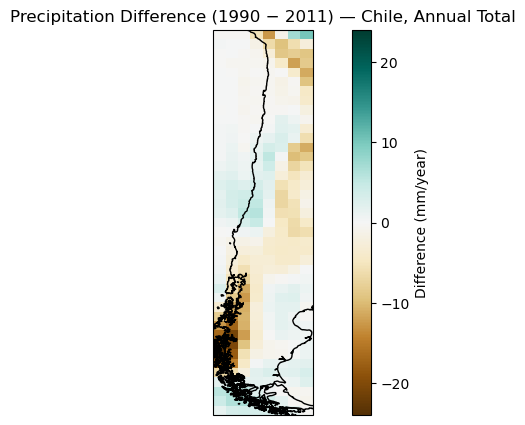

In [66]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# --- Chile bounds
lat_chile = slice(-56, -17)
lon_chile = slice(284, 294)

# --- Load annual data for both years
ds_pr_1990 = ds['pr'].sel(time=slice('1990-01-01', '1990-12-31'), lat=lat_chile, lon=lon_chile)
ds_pr_2011 = ds['pr'].sel(time=slice('2011-01-01', '2011-12-31'), lat=lat_chile, lon=lon_chile)

# --- Convert to mm/day and sum to get mm/year
pr_1990 = ds_pr_1990.isel(member_id=0, dcpp_init_year=0) * 86400
pr_2011 = ds_pr_2011.isel(member_id=0, dcpp_init_year=0) * 86400

pr_total_1990 = pr_1990.sum(dim='time')
pr_total_2011 = pr_2011.sum(dim='time')

# --- Compute difference
pr_diff = pr_total_1990 - pr_total_2011  # mm/year

# --- Plot
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
pr_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG', center=0,
             cbar_kwargs={'label': 'Difference (mm/year)'})
ax.coastlines()
ax.set_title('Precipitation Difference (1990 − 2011) — Chile, Annual Total')
plt.show()

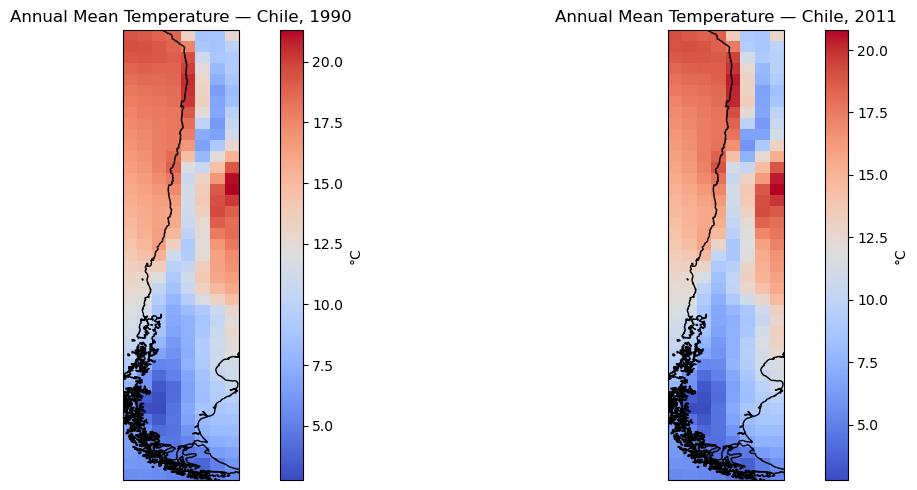

In [68]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# --- Chile bounds
lat_chile = slice(-56, -17)
lon_chile = slice(284, 294)

# --- Select annual temperature data
ds_tas_1990 = ds_tas['tas'].sel(time=slice('1990-01-01', '1990-12-31'), lat=lat_chile, lon=lon_chile)
ds_tas_2011 = ds_tas['tas'].sel(time=slice('2011-01-01', '2011-12-31'), lat=lat_chile, lon=lon_chile)

# --- Convert from Kelvin to Celsius and average over year
tas_1990 = ds_tas_1990.isel(member_id=0, dcpp_init_year=0) - 273.15
tas_2011 = ds_tas_2011.isel(member_id=0, dcpp_init_year=0) - 273.15

tas_1990_mean = tas_1990.mean(dim='time')
tas_2011_mean = tas_2011.mean(dim='time')

# --- Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# 1990
tas_1990_mean.plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': '°C'})
axes[0].set_title('Annual Mean Temperature — Chile, 1990')
axes[0].coastlines()

# 2011
tas_2011_mean.plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': '°C'})
axes[1].set_title('Annual Mean Temperature — Chile, 2011')
axes[1].coastlines()

plt.tight_layout()
plt.show()

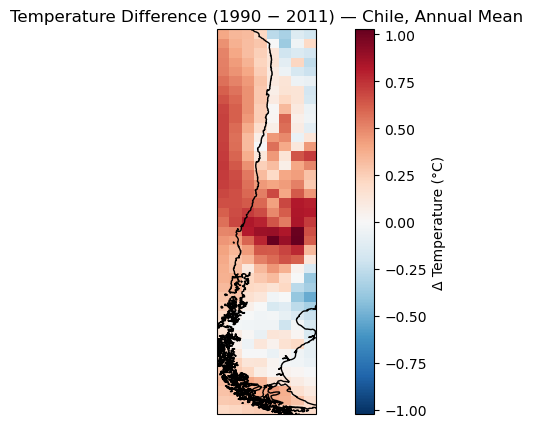

In [69]:
# --- Compute difference (°C)
tas_diff = tas_1990_mean - tas_2011_mean

# --- Plot difference
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
tas_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', center=0,
              cbar_kwargs={'label': 'Δ Temperature (°C)'})
ax.coastlines()
ax.set_title('Temperature Difference (1990 − 2011) — Chile, Annual Mean')
plt.show()